In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Parcelas consultadas desde recurso externo 

Se cargan variables explicativas obtenidas desde un recurso externo. En este caso, se usan atributos de la parcela obtenidos desde la API de catastro del GCBA (ver notebook `catastro_api`).

In [2]:
expvars_df = pd.read_csv('../data/catastroapi_parcel_fields.csv')

In [3]:
expvars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52372 entries, 0 to 52371
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   smp                   52372 non-null  object 
 1   direccion             48679 non-null  object 
 2   seccion               52372 non-null  float64
 3   manzana               52372 non-null  object 
 4   parcela               52372 non-null  object 
 5   srid                  49081 non-null  float64
 6   smp_anterior          49081 non-null  object 
 7   smp_siguiente         49081 non-null  object 
 8   pdamatriz             48130 non-null  float64
 9   superficie_total      48130 non-null  float64
 10  superficie_cubierta   48130 non-null  float64
 11  frente                48130 non-null  float64
 12  fondo                 48130 non-null  float64
 13  propiedad_horizontal  48130 non-null  float64
 14  pisos_bajo_rasante    48130 non-null  float64
 15  pisos_sobre_rasante

# 2. Revisión de parcelas (SMP)

In [4]:
from REM.datasources import *

Se integra un único área de estudio con las parcelas dentro de las comunas del sur de la Ciudad y el polígono de la subárea de interés. El objetivo de este paso es contar con variables explicativas para toda la zona sur.

In [5]:
# Parcelas CABA
parcelas = caba_parcelas(source_idx=1)

Reading parcels from local dir ...


In [6]:
# Polígonos de las comunas del sur
comunas_sur = comunas(idx=[4,8])

In [7]:
# Área de interés
area_estudio = thiner_bound(path='../data/BarOli_V1/layers/P_BP_AREA_5347.shp').to_crs(comunas_sur.crs)

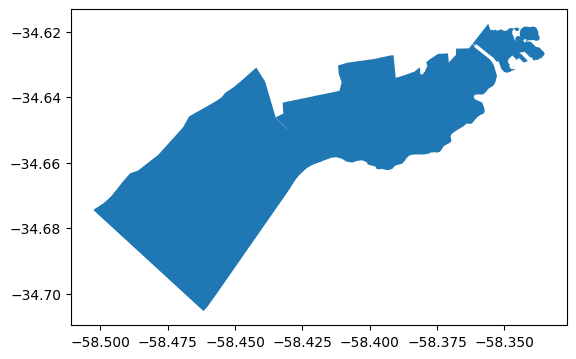

In [9]:
f, ax = plt.subplots()
comunas_sur.plot(ax=ax)
area_estudio.plot(ax=ax);

In [10]:
# Combinamos polígonos en un único área
myGeomList = comunas_sur.geometry.to_list()+area_estudio.geometry.to_list()

In [11]:
from shapely.ops import unary_union
cu = unary_union(myGeomList)

In [12]:
focus_area = parcelas.clip(cu)

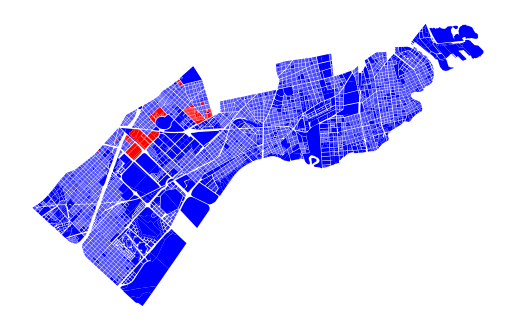

In [13]:
f, ax = plt.subplots()
focus_area[focus_area.smp.isin(expvars_df.smp.unique())].plot(ax=ax, color='blue')
focus_area[~focus_area.smp.isin(expvars_df.smp.unique())].plot(ax=ax, color='red')
ax.set_axis_off();

In [14]:
# SMP descargados de la API no encontradas en dataset de parcelas
len(focus_area[~focus_area.smp.isin(expvars_df.smp.unique())])

172

In [15]:
focus_area[~focus_area.smp.isin(expvars_df.smp.unique())]['smp'].reset_index()

,index,smp
0,127361,044-132-000A
1,129328,044-131-000A
2,125398,044-129A-000D
3,125403,044-129A-000J
4,125994,044-129A-000K
...,...,...
167,180735,056-099-000C
168,180252,056-113B-000R
169,180690,056-113B-000V
170,180691,056-113B-000W


In [16]:
last_miss = focus_area[~focus_area.smp.isin(expvars_df.smp.unique())].reset_index()

In [17]:
last_miss['smp']

0       044-132-000A
1       044-131-000A
2      044-129A-000D
3      044-129A-000J
4      044-129A-000K
           ...      
167     056-099-000C
168    056-113B-000R
169    056-113B-000V
170    056-113B-000W
171     064-107-000J
Name: smp, Length: 172, dtype: object

In [18]:
# Se corrige idx consumido para acomodarlo al formato de nuestra db de parcelas
corrections = []
for idx in last_miss.smp:
    if idx[-1].isupper():
        corrections.append(idx[:-1]+idx[-1].lower())
    else:
        corrections.append(idx)
        # parcelas no encontradas
        print(idx)

044-002U-002
044-048L-001
044-048L-002
050-080A-000Ã‘
044-102-000Ã‘
044-058-005Ã±
056-036-003
056-036-002
056-036-001


In [19]:
# rechequeo con idx parcelas corregidos
last_miss['smp_'] = corrections
corr = dict(zip(last_miss['smp'], last_miss['smp_']))
focus_area['smp_'] = focus_area.smp.replace(corr)

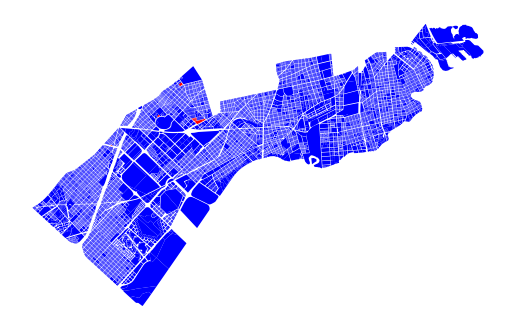

In [20]:
f, ax = plt.subplots()
focus_area[focus_area['smp_'].isin(expvars_df['smp'].unique())].plot(ax=ax, color='blue')
focus_area[~focus_area['smp_'].isin(expvars_df['smp'].unique())].plot(ax=ax, color='red')
ax.set_axis_off();

In [21]:
parcelas_sur = focus_area.copy()

# 3. Variables explicativas

Se realiza limpieza final, discriminando variables explicativas para modelo de precios (atributos de las parcelas). Los valores nulos se completan a partir del promedio de los N vecinos más cecanos.

In [22]:
gkbs = '+proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs'

parcelas_sur['lon_ctroid'] = parcelas_sur.to_crs(gkbs).geometry.centroid.x
parcelas_sur['lat_ctroid'] = parcelas_sur.to_crs(gkbs).geometry.centroid.y

In [23]:
parcelas_sur.drop(columns='smp', inplace=True)
parcelas_sur.rename(columns={'smp_':'smp'}, inplace=True)

In [24]:
expvar_names = ['smp',
                'superficie_total', 'superficie_cubierta',
                'frente','fondo',
                'propiedad_horizontal',
                'pisos_bajo_rasante',
                'pisos_sobre_rasante',
                'unidades_funcionales',
                'locales',
                'vuc',
                'cantidad_puertas']

In [25]:
# Parcelas que no existen en la API de catastro
len(parcelas_sur.loc[~parcelas_sur['smp'].isin(expvars_df['smp'].unique())])

18

In [26]:
expvars = expvars_df[expvar_names].copy().set_index('smp')

In [27]:
# Parcelas en area de recorte
len(expvars)

52372

In [28]:
parcelas_sur.columns

Index(['fid_1', 'featid1', 'manzana', 'obs', 'parcela', 'seccion', 'partida',
       'sup_edif', 'unidades', 'fid_2', 'barrios', 'comuna', 'area',
       'perimeter', 'acres', 'dist_m2', 'hectares', 'geometry', 'smp',
       'lon_ctroid', 'lat_ctroid'],
      dtype='object')

In [29]:
observed_data = parcelas_sur[['smp','lat_ctroid','lon_ctroid']].set_index('smp').copy()
model_data_ = observed_data.join(expvars)

### 3.1. Imputación de valores perdidos

In [30]:
model_data = model_data_[expvar_names[1:]].copy()

In [31]:
len(model_data)

52400

In [32]:
from REM.utils import neighbors_mean

In [33]:
# dimensiones de los 5 vecinos mas cercanos
dim_vecinos = neighbors_mean(base_data=model_data, observation_cols=expvar_names[1:5], n=5, devuelve_matriz=True)

In [34]:
# construcciones de los 5 vecinos mas cercanos
con_vecinos = neighbors_mean(base_data=model_data, observation_cols=expvar_names[5:12], n=5, devuelve_matriz=True)

In [35]:
model_data.iloc[:,0:4] = dim_vecinos
model_data.iloc[:,4:11] = con_vecinos

In [36]:
model_data.iloc[:,4:11]

,propiedad_horizontal,pisos_bajo_rasante,pisos_sobre_rasante,unidades_funcionales,locales,vuc,cantidad_puertas
smp,,,,,,,
006-001A-000B,0.237752,0.003968,1.304384,2.057428,0.0,0.0,1.769626
006-001A-000C,0.237752,0.003968,1.304384,2.057428,0.0,0.0,1.769626
006-001A-001a,0.000000,0.000000,1.000000,0.000000,0.0,0.0,5.000000
006-001A-002a,0.000000,0.000000,1.000000,0.000000,0.0,0.0,1.000000
006-001A-003b,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000
...,...,...,...,...,...,...,...
096-019-000N,0.237752,0.003968,1.304384,2.057428,0.0,0.0,1.769626
096-020-000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,2.000000
098-063A-001,0.237752,0.003968,1.304384,2.057428,0.0,0.0,1.769626


In [37]:
len(model_data)

52400

In [38]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52400 entries, 006-001A-000B to 098-063P-000
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   superficie_total      52400 non-null  float64
 1   superficie_cubierta   52400 non-null  float64
 2   frente                52400 non-null  float64
 3   fondo                 52400 non-null  float64
 4   propiedad_horizontal  52400 non-null  float64
 5   pisos_bajo_rasante    52400 non-null  float64
 6   pisos_sobre_rasante   52400 non-null  float64
 7   unidades_funcionales  52400 non-null  float64
 8   locales               52400 non-null  float64
 9   vuc                   52400 non-null  float64
 10  cantidad_puertas      52400 non-null  float64
dtypes: float64(11)
memory usage: 4.8+ MB


In [39]:
model_data.sample(5)

,superficie_total,superficie_cubierta,frente,fondo,propiedad_horizontal,pisos_bajo_rasante,pisos_sobre_rasante,unidades_funcionales,locales,vuc,cantidad_puertas
smp,,,,,,,,,,,
038-014B-003,214.0,142.0,8.66,24.71,0.0,0.0,1.0,0.0,0.0,0.0,1.0
066-005B-012,195.0,106.0,8.69,22.44,1.0,0.0,1.0,2.0,0.0,0.0,1.0
066-090-012,324.0,241.0,8.66,37.41,0.0,0.0,1.0,0.0,0.0,0.0,1.0
032-059-001d,151.0,140.0,16.47,9.17,1.0,0.0,1.0,3.0,0.0,0.0,3.0
010-069-019,166.0,261.0,8.66,19.17,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [40]:
# recupera centroide de parcelas
model_data['lon_ctroid'], model_data['lat_ctroid'] = model_data_['lon_ctroid'], model_data_['lat_ctroid']

In [41]:
model_data.to_csv('../data/expvars_12092022.csv')